# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [11]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from image_loader import LoadImage
from image_genarator import create_datagen, create_generator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [9]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Contruct a CNN**

### *Load and Preprocessing images*

In [12]:
#Create a generator to preprocessing images using the class ImageDataGenerator
train_datagen = create_datagen(
    rotation_range=10, #rotating images 10º
    width_shift_range=0.1, #traslating images 10%
    height_shift_range=0.1, #traslating images 10%
    zoom_range=0.1, #10% zoom
    horizontal_flip=True) 

val_datagen = create_datagen()

test_datagen = ImageDataGenerator()

In [15]:
#Load and preprocessing images
train_generator = create_generator(train_datagen, train_dir)

val_generator = create_generator(val_datagen, val_dir, shuffle=False)

test_generator = create_generator(test_datagen, test_dir, shuffle=False)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


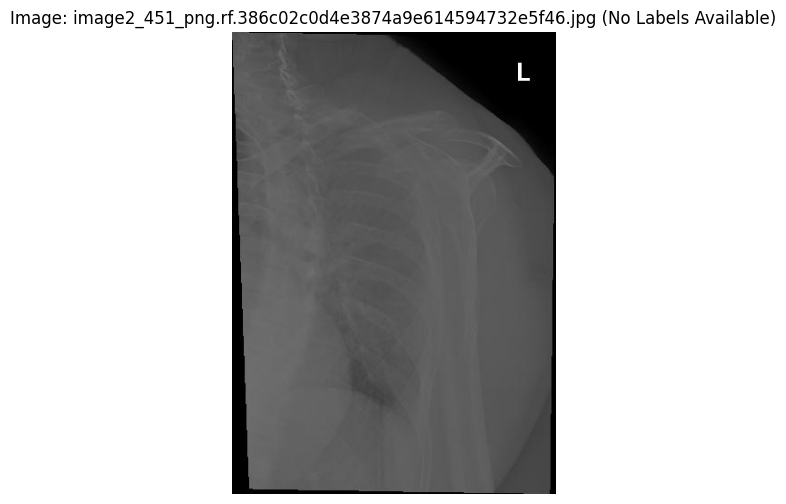

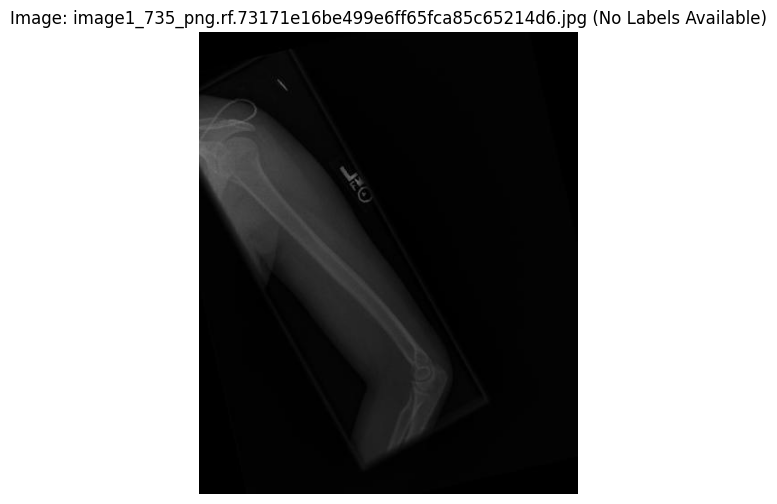

In [14]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----

### *Model 1*

In [5]:
#Construct the model 
model_CNN1 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN1.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN1.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN1.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN1.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN1.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN1.add(layers.Dense(1, activation='sigmoid'))

model_CNN1.summary()

I0000 00:00:1731581482.997619 3959144 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

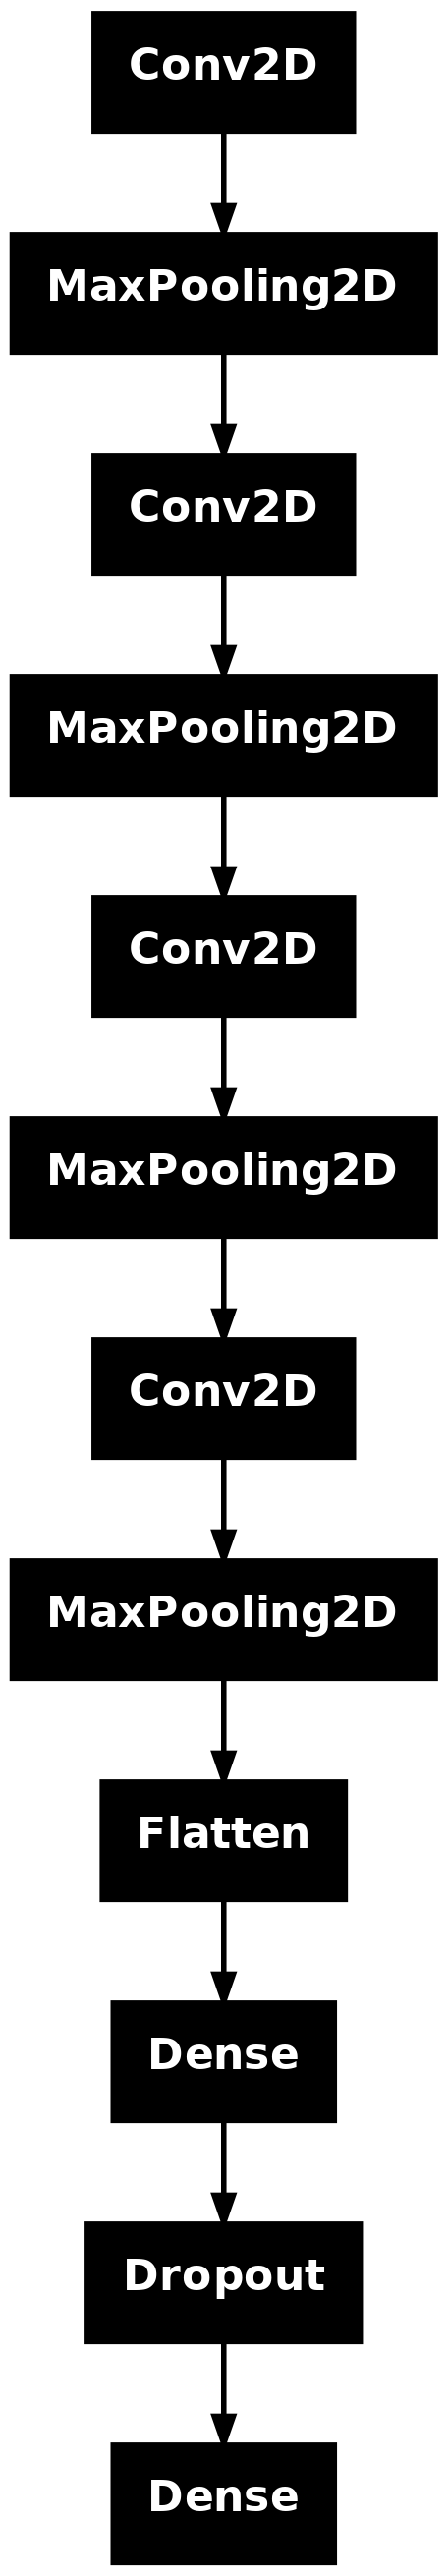

In [6]:
tf.keras.utils.plot_model(model_CNN1)

In [7]:
model_CNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [10]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=3,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True  
)

#Train the model 
history = model_CNN1.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.6358 - loss: 0.6266 - val_accuracy: 0.5870 - val_loss: 0.6605 - learning_rate: 3.9063e-06
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.7209 - loss: 0.5770

2024-11-14 12:21:49.593178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 12:21:49.593207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7146 - loss: 0.5811 - val_accuracy: 0.5854 - val_loss: 0.6611 - learning_rate: 3.9063e-06
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.6450 - loss: 0.6200 - val_accuracy: 0.5854 - val_loss: 0.6642 - learning_rate: 3.9063e-06
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.6020 - loss: 0.6308

2024-11-14 12:22:21.961539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 12:22:21.961567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6205 - loss: 0.6317 - val_accuracy: 0.5837 - val_loss: 0.6641 - learning_rate: 3.9063e-06


### *Model graphs*

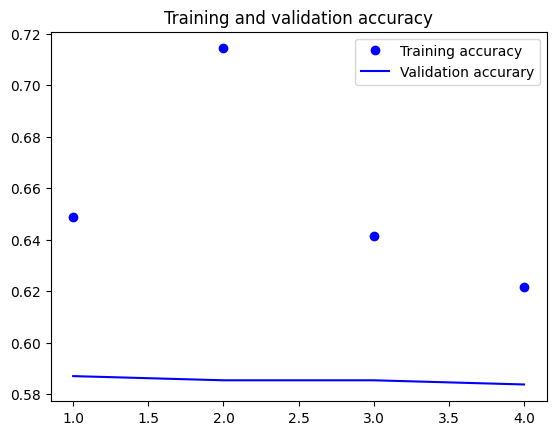

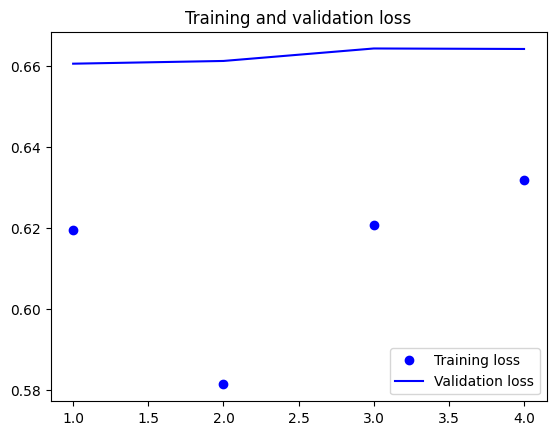

In [11]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

------

In [12]:
#Same model but patient 10 instead of 3

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=10,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=10,              
    restore_best_weights=True  
)

#Train the model 
history = model_CNN1.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.6481 - loss: 0.6192 - val_accuracy: 0.5821 - val_loss: 0.6616 - learning_rate: 1.9531e-06
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.6790 - loss: 0.5765

2024-11-14 12:40:44.164901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 12:40:44.164934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6514 - loss: 0.6077 - val_accuracy: 0.5821 - val_loss: 0.6615 - learning_rate: 1.9531e-06
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.6417 - loss: 0.6180 - val_accuracy: 0.5854 - val_loss: 0.6620 - learning_rate: 1.9531e-06
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6381 - loss: 0.6009 - val_accuracy: 0.5854 - val_loss: 0.6621 - learning_rate: 1.9531e-06
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.6407 - loss: 0.6187 - val_accuracy: 0.5854 - val_loss: 0.6624 - learning_rate: 1.9531e-06
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.6068 - loss: 0.6179

2024-11-14 12:41:49.882106: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 12:41:49.882138: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6207 - loss: 0.6333 - val_accuracy: 0.5854 - val_loss: 0.6624 - learning_rate: 1.9531e-06
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6370 - loss: 0.6316 - val_accuracy: 0.5854 - val_loss: 0.6623 - learning_rate: 1.9531e-06
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6369 - loss: 0.6014 - val_accuracy: 0.5854 - val_loss: 0.6625 - learning_rate: 1.9531e-06
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.6439 - loss: 0.6174 - val_accuracy: 0.5854 - val_loss: 0.6631 - learning_rate: 1.9531e-06
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.6998 - loss: 0.5941

2024-11-14 12:42:55.291561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6932 - loss: 0.5896 - val_accuracy: 0.5854 - val_loss: 0.6631 - learning_rate: 1.9531e-06
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6501 - loss: 0.6182 - val_accuracy: 0.5870 - val_loss: 0.6635 - learning_rate: 1.9531e-06
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.6639 - loss: 0.6071

2024-11-14 12:43:28.191075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7119 - loss: 0.5915 - val_accuracy: 0.5870 - val_loss: 0.6635 - learning_rate: 1.0000e-06


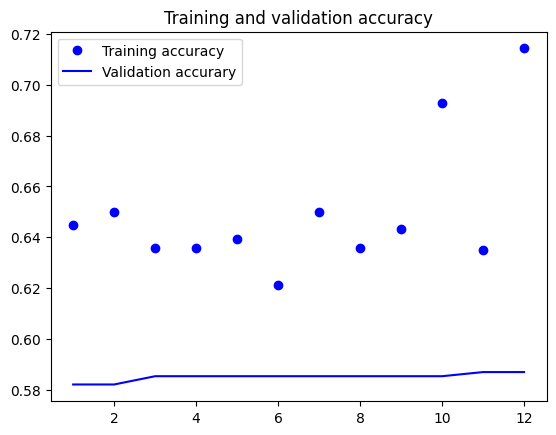

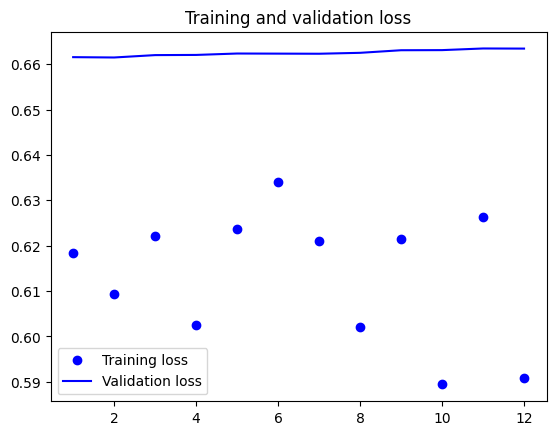

In [13]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

----

In [17]:
optimizer = Adam(learning_rate=1e-4)
model_CNN1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [22]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

#Train the model 
history = model_CNN1.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.6469 - loss: 0.6129 - val_accuracy: 0.6341 - val_loss: 0.6485 - learning_rate: 5.0000e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6917 - loss: 0.6127 - val_accuracy: 0.6130 - val_loss: 0.6533 - learning_rate: 5.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.6579 - loss: 0.6099 - val_accuracy: 0.5691 - val_loss: 0.6688 - learning_rate: 5.0000e-05
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.6059 - loss: 0.6289

2024-11-14 13:20:09.175222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 13:20:09.175249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6275 - loss: 0.6160 - val_accuracy: 0.6049 - val_loss: 0.6581 - learning_rate: 5.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6591 - loss: 0.6040 - val_accuracy: 0.6033 - val_loss: 0.6573 - learning_rate: 5.0000e-05
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - accuracy: 0.7173 - loss: 0.6398

2024-11-14 13:20:42.217270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 13:20:42.217303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6668 - loss: 0.6380 - val_accuracy: 0.6130 - val_loss: 0.6515 - learning_rate: 5.0000e-05


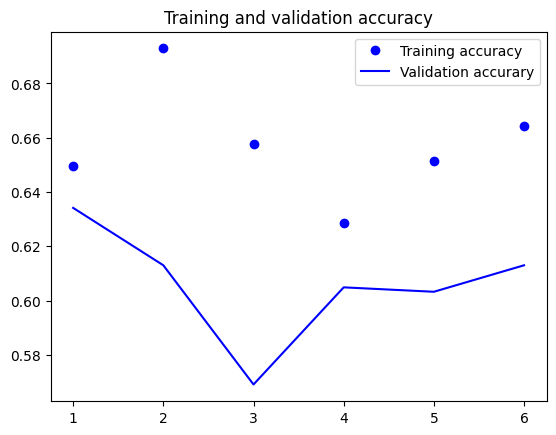

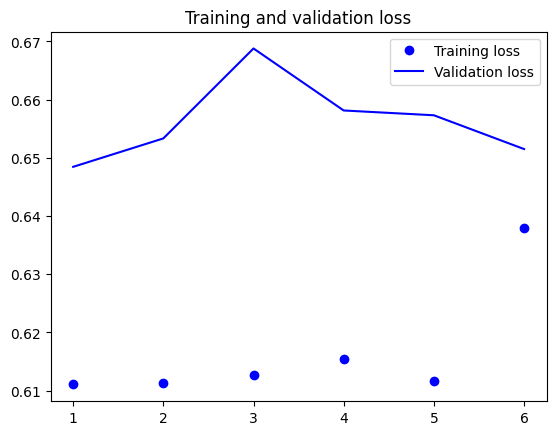

In [23]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

------------

### *Model 2*

In [34]:
#Construct the model 
model_CNN2 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN2.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Dropout(0.3)) #add a dropout
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN2.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN2.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN2.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

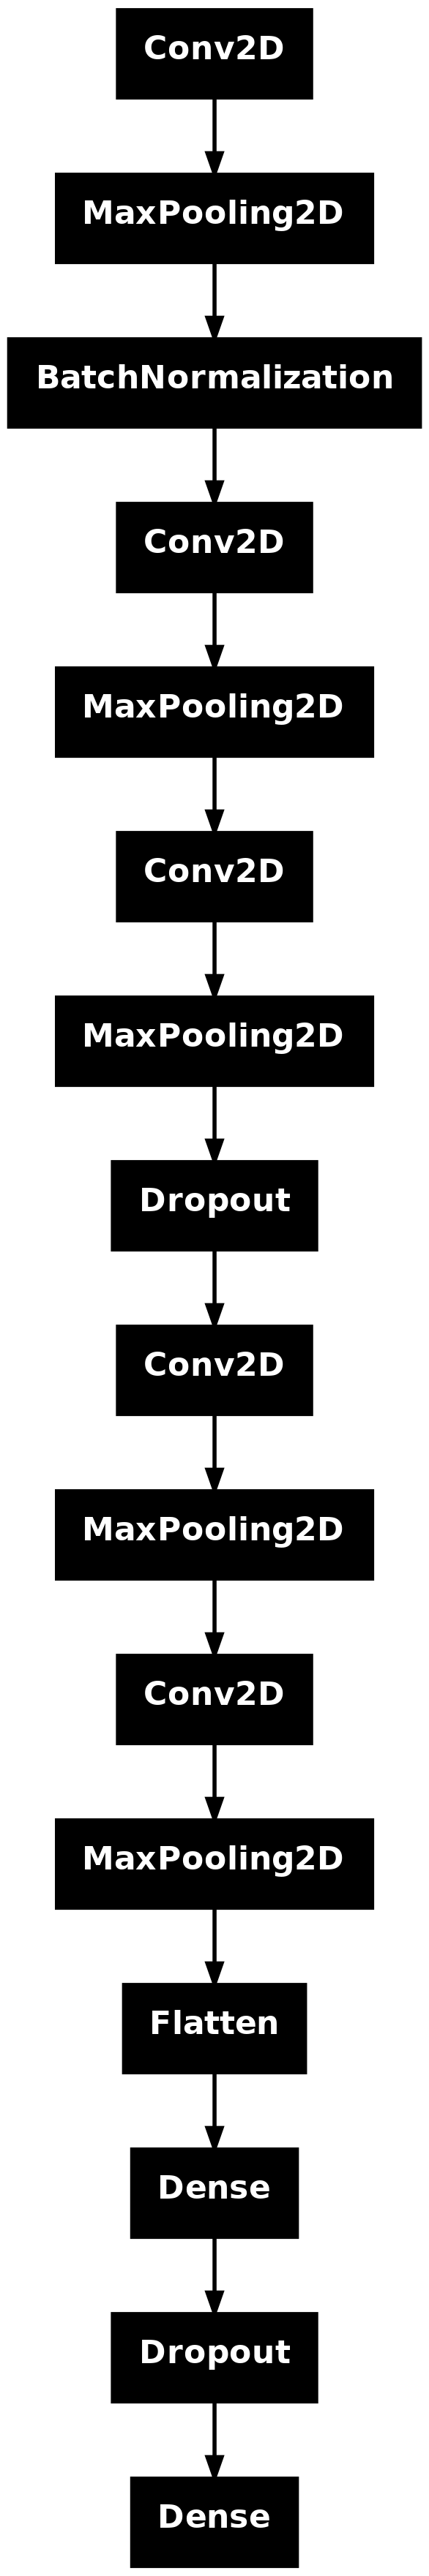

In [35]:
tf.keras.utils.plot_model(model_CNN2)

In [36]:
optimizer = Adam(learning_rate=1e-3)
model_CNN2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

#Train the model 
history = model_CNN2.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.5874 - loss: 0.8022 - val_accuracy: 0.4959 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.6556 - loss: 0.6679

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6639 - loss: 0.6597 - val_accuracy: 0.4959 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.5996 - loss: 0.6756 - val_accuracy: 0.4959 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.5541 - loss: 0.6921

2024-11-14 14:13:19.331336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 14:13:19.331375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6183 - loss: 0.6746 - val_accuracy: 0.4959 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.5963 - loss: 0.6806 - val_accuracy: 0.4959 - val_loss: 0.7081 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.6085 - loss: 0.6816

2024-11-14 14:13:51.916278: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 14:13:51.916311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5936 - loss: 0.6861 - val_accuracy: 0.4959 - val_loss: 0.7119 - learning_rate: 0.0010


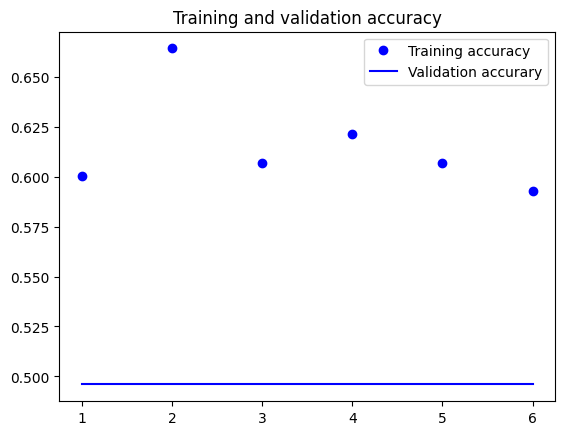

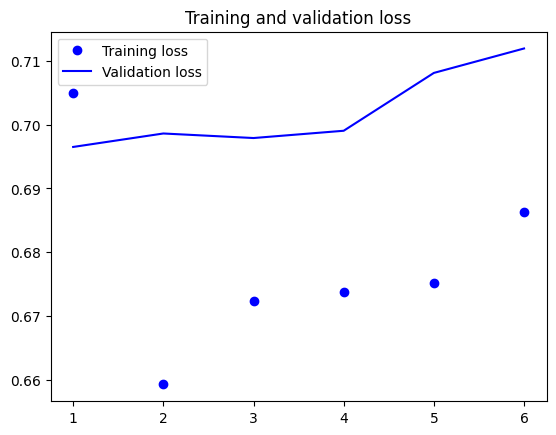

In [38]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

---------

### *Model 3*

In [39]:
#Construct the model 
model_CNN3 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN3.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L2 regularization
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Dropout(0.4)) #add a dropout
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN3.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN3.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

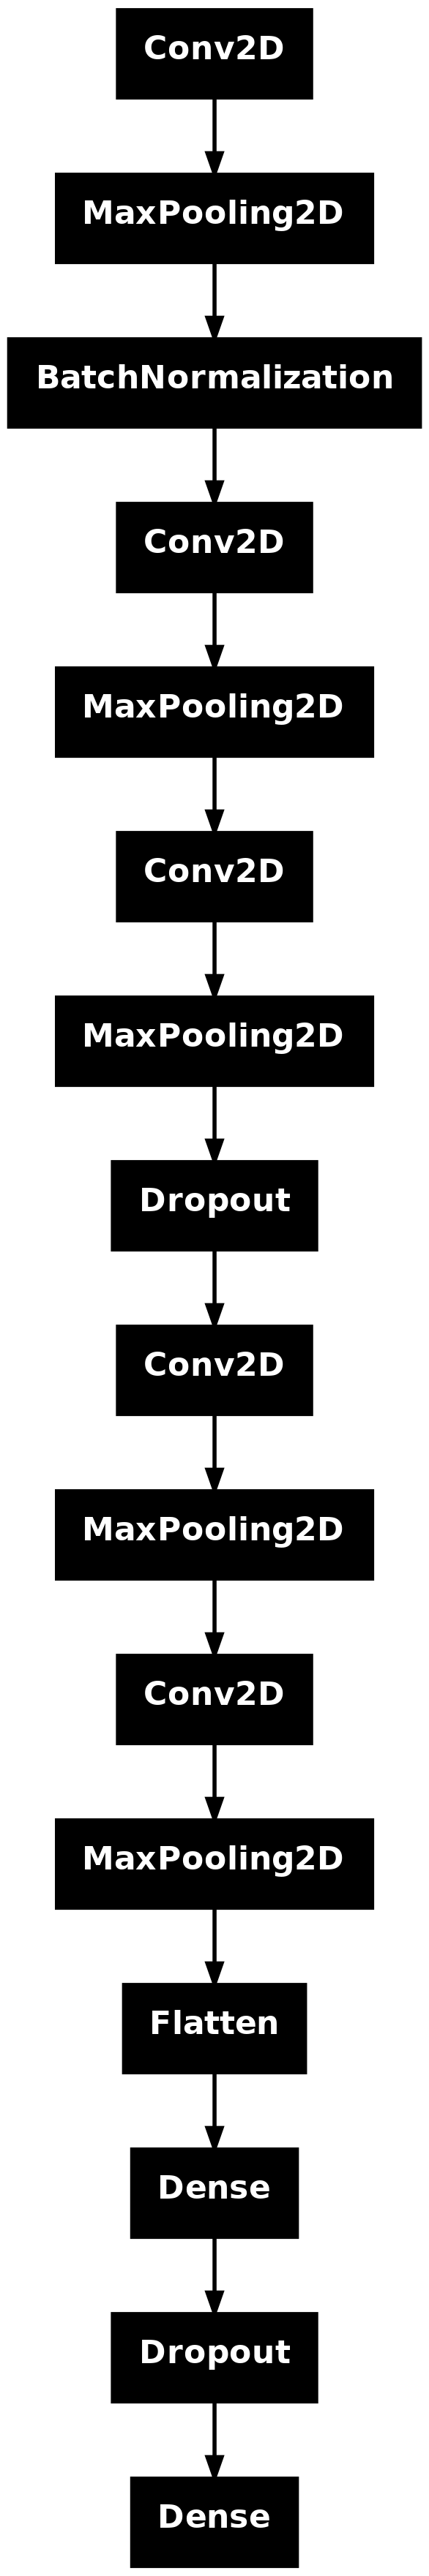

In [40]:
tf.keras.utils.plot_model(model_CNN3)

In [41]:
optimizer = Adam(learning_rate=1e-3)
model_CNN3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

#Train the model 
history = model_CNN3.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.5543 - loss: 6.8166 - val_accuracy: 0.4959 - val_loss: 1.0909 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.6632 - loss: 1.0368

2024-11-14 14:25:02.343475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-14 14:25:02.343523: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5893 - loss: 1.0639 - val_accuracy: 0.4959 - val_loss: 1.0558 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.5989 - loss: 0.9127 - val_accuracy: 0.4959 - val_loss: 0.7776 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5912 - loss: 0.7483 - val_accuracy: 0.4959 - val_loss: 0.7743 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.5954 - loss: 0.7270 - val_accuracy: 0.4959 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.6700 - loss: 0.6709

2024-11-14 14:26:08.282502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 14:26:08.282534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6305 - loss: 0.6985 - val_accuracy: 0.4959 - val_loss: 0.7424 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.5881 - loss: 0.6966 - val_accuracy: 0.4959 - val_loss: 0.7528 - learning_rate: 0.0010
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.6895 - loss: 0.6283

2024-11-14 14:26:42.049383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 14:26:42.049413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6450 - loss: 0.6632 - val_accuracy: 0.4959 - val_loss: 0.7419 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.6137 - loss: 0.6745 - val_accuracy: 0.4959 - val_loss: 0.7258 - learning_rate: 0.0010
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.6366 - loss: 0.6543

2024-11-14 14:27:14.814189: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6221 - loss: 0.6646 - val_accuracy: 0.4959 - val_loss: 0.7304 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.5851 - loss: 0.6840 - val_accuracy: 0.4959 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.5987 - loss: 0.6784

2024-11-14 14:27:48.526702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6136 - loss: 0.6682 - val_accuracy: 0.4959 - val_loss: 0.7342 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6160 - loss: 0.6672 - val_accuracy: 0.4959 - val_loss: 0.7167 - learning_rate: 0.0010
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.5532 - loss: 0.6996

2024-11-14 14:28:21.389521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 14:28:21.389550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5978 - loss: 0.6801 - val_accuracy: 0.4959 - val_loss: 0.7165 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.6019 - loss: 0.6740 - val_accuracy: 0.4959 - val_loss: 0.7360 - learning_rate: 0.0010
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6138 - loss: 0.6737 - val_accuracy: 0.4959 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.6051 - loss: 0.6728 - val_accuracy: 0.4959 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 18/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6209 - loss: 0.6663 - val_accuracy: 0.4959 - val_loss: 0.7153 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.6137 - loss: 0.6689 - val_accuracy: 0.4959 - val_loss: 0.7224 - learning_rate: 0.0010
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.6271 -

2024-11-14 14:29:59.086949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10644818540820008711
2024-11-14 14:29:59.086983: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16337008813292233592


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5876 - loss: 0.6800 - val_accuracy: 0.4959 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.6051 - loss: 0.6724 - val_accuracy: 0.4959 - val_loss: 0.7242 - learning_rate: 0.0010
Epoch 22/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6409 - loss: 0.6548 - val_accuracy: 0.4959 - val_loss: 0.7315 - learning_rate: 0.0010


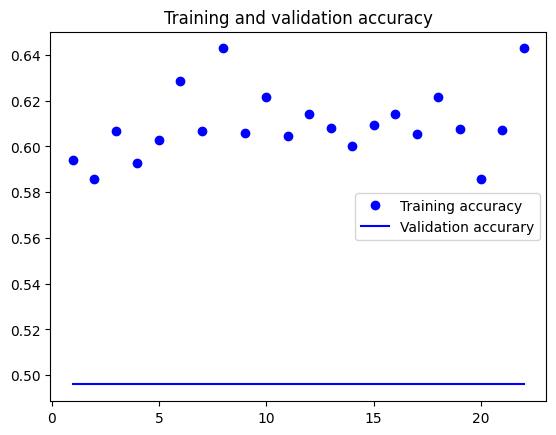

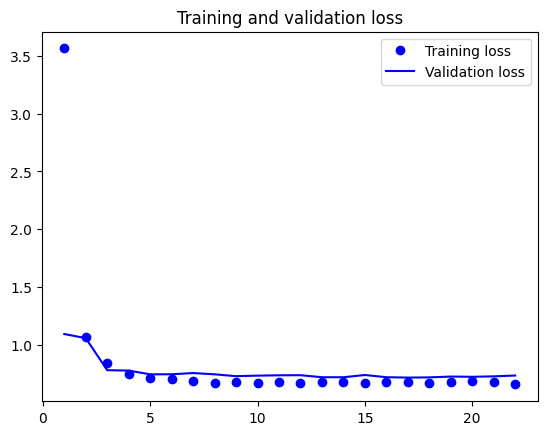

In [43]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

------------

### **Pretrained network VGG16**

In [18]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 242, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 242, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 242, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 242, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 121, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 121, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 121, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

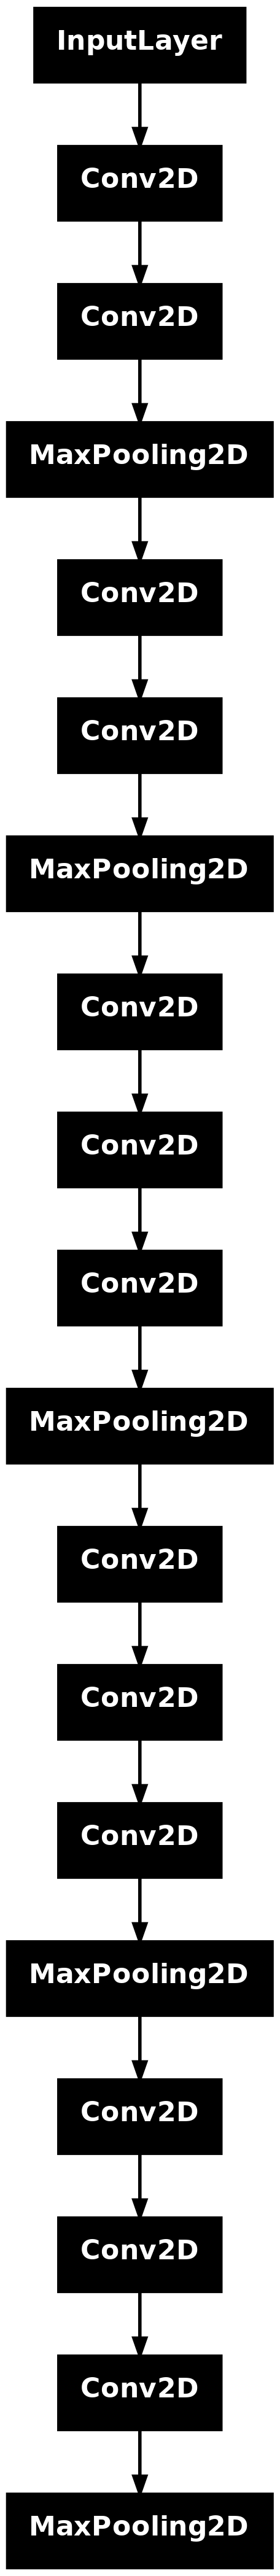

In [19]:
tf.keras.utils.plot_model(conv_base_VGG16)

In [25]:
#Load and preprocessing images
train_generator = create_generator(train_datagen, train_dir, target_size = (224, 224))
val_generator = create_generator(val_datagen, val_dir, target_size = (224, 224), shuffle = False)
test_generator = create_generator(test_datagen, test_dir, target_size = (224, 224), shuffle = False)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


### *Transfer learning*

### *Model 1*

In [26]:
model_VGG16_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_1.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_1.add(layers.Flatten())  # Flatten extracted features
model_VGG16_1.add(layers.Dense(256, activation='relu'))  # CFull-connected layer
model_VGG16_1.add(layers.Dropout(0.5))  #To avoid over-fitting
model_VGG16_1.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

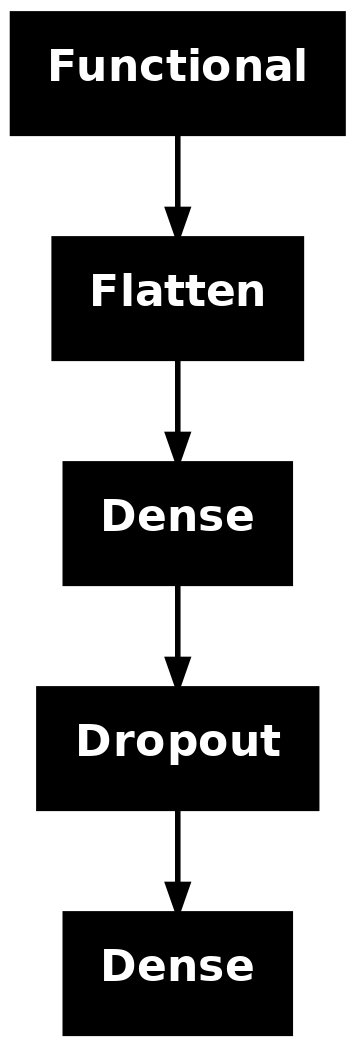

In [21]:
tf.keras.utils.plot_model(model_VGG16_1)

In [27]:
model_VGG16_1.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,          
    min_lr=1e-6
)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

#Train the model 
history = model_VGG16_1.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "vgg16" is incompatible with the layer: expected shape=(None, 224, 242, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

In [30]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
print("Primeras 10 etiquetas:", y_batch[:10])

x_batch shape: (20, 224, 224, 3), y_batch shape: (20,)
Primeras 10 etiquetas: [0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]


#train_dir = "../1-Data/ml-dp/train"
loader = LoadImage(train_dir)

images_train = loader.images
names_train = loader.names

print(f"Number of images: {len(images_train)}") 
loader.plot_images_with_bboxes() 

loader = LoadImage(image_path='/ruta/a/imagenes', label_path='/ruta/a/labels')

#Train
preprocessor_train = PreprocessImage(images_train) 
resized_images_train, _ = preprocessor_train.resize_images_and_labels() #_ indicates that we don't have labels

resized_preprocessor_train = PreprocessImage(resized_images_train)
gray_images_train = resized_preprocessor_train.convert_to_grayscale()

normalized_preprocessor_train = PreprocessImage(gray_images_train)
normalized_images_train = normalized_preprocessor_train.normalize_images()

preprocessor = PreprocessImage(images, labels)
resized_images, labels = preprocessor.resize_images_and_labels()